# Imports

In [245]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageChops
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Helper Functions

In [246]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

# Configuration Class

In [247]:
class Config():
    train_dir = '/data/rgbd_face_data/att/train'
    test_dir = '/data/rgbd_face_data/att/test'
    train_batch_size = 64
    train_number_epochs = 1000

# Custom Dataset Class

In [262]:
class FaceIdDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, should_invert=False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
    
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_face = random.randint(0,1)
        should_invert = random.randint(0,1)
        if should_get_same_face:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert('L')
        img1 = img1.convert('L')
        
        if self.should_invert:
            if random.randint(0,1):
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
                
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [249]:
train_dataset = dset.ImageFolder(root=Config.train_dir)

In [250]:
faceid_dataset = FaceIdDataset(imageFolderDataset=train_dataset,
                               transform=transforms.Compose([transforms.Resize((100,100)),
                                                             transforms.ToTensor()]))

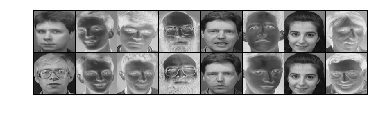

[[1. 0. 1. 0. 0. 0. 0. 1.]]


In [251]:
vis_dataloader = DataLoader(faceid_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape((1,8)))

# Neural Network Architecture

In [252]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8))
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500, 5))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss Function

In [253]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output0, output1, label):
        l2_norm = F.pairwise_distance(output0, output1)
        contrastive_loss = torch.mean((1-label) * torch.pow(l2_norm, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - l2_norm, min=0.0), 2))
        
        return contrastive_loss

# Train...

In [254]:
train_dataloader = DataLoader(faceid_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=Config.train_batch_size)

In [258]:
nnet = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(nnet.parameters(), lr = 0.0005)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [259]:
counter = []
loss_history = []
iteration = 0

Epoch number 0
 Current loss 2.06813645362854

Epoch number 1
 Current loss 2.6442110538482666

Epoch number 2
 Current loss 1.2471193075180054

Epoch number 3
 Current loss 1.1936707496643066

Epoch number 4
 Current loss 1.1971538066864014

Epoch number 5
 Current loss 1.2826725244522095

Epoch number 6
 Current loss 1.2627776861190796

Epoch number 7
 Current loss 1.2036948204040527

Epoch number 8
 Current loss 1.1707484722137451

Epoch number 9
 Current loss 1.2417410612106323

Epoch number 10
 Current loss 1.3672325611114502

Epoch number 11
 Current loss 1.2349445819854736

Epoch number 12
 Current loss 1.1638520956039429

Epoch number 13
 Current loss 1.248045563697815

Epoch number 14
 Current loss 1.2146257162094116

Epoch number 15
 Current loss 1.208042025566101

Epoch number 16
 Current loss 1.2894256114959717

Epoch number 17
 Current loss 1.1025071144104004

Epoch number 18
 Current loss 1.2404543161392212

Epoch number 19
 Current loss 1.1091644763946533

Epoch number 2

Epoch number 164
 Current loss 1.0387955904006958

Epoch number 165
 Current loss 1.0602208375930786

Epoch number 166
 Current loss 0.9945905208587646

Epoch number 167
 Current loss 1.0963119268417358

Epoch number 168
 Current loss 1.0107096433639526

Epoch number 169
 Current loss 1.0484609603881836

Epoch number 170
 Current loss 1.0657215118408203

Epoch number 171
 Current loss 1.0349560976028442

Epoch number 172
 Current loss 1.0420289039611816

Epoch number 173
 Current loss 1.0318310260772705

Epoch number 174
 Current loss 1.0577419996261597

Epoch number 175
 Current loss 1.035048007965088

Epoch number 176
 Current loss 1.055022954940796

Epoch number 177
 Current loss 0.947316586971283

Epoch number 178
 Current loss 1.0525281429290771

Epoch number 179
 Current loss 1.0032826662063599

Epoch number 180
 Current loss 1.0549464225769043

Epoch number 181
 Current loss 1.010237455368042

Epoch number 182
 Current loss 1.0547395944595337

Epoch number 183
 Current loss 1.00

Epoch number 326
 Current loss 1.079268217086792

Epoch number 327
 Current loss 1.0441904067993164

Epoch number 328
 Current loss 1.065284013748169

Epoch number 329
 Current loss 1.032305121421814

Epoch number 330
 Current loss 1.0501301288604736

Epoch number 331
 Current loss 1.0775091648101807

Epoch number 332
 Current loss 1.0691720247268677

Epoch number 333
 Current loss 1.0168935060501099

Epoch number 334
 Current loss 1.0594981908798218

Epoch number 335
 Current loss 1.021843433380127

Epoch number 336
 Current loss 1.0667448043823242

Epoch number 337
 Current loss 1.024789810180664

Epoch number 338
 Current loss 1.078941822052002

Epoch number 339
 Current loss 1.0094177722930908

Epoch number 340
 Current loss 1.0382943153381348

Epoch number 341
 Current loss 1.068864345550537

Epoch number 342
 Current loss 1.0640989542007446

Epoch number 343
 Current loss 1.0357661247253418

Epoch number 344
 Current loss 1.0537320375442505

Epoch number 345
 Current loss 1.00655

Epoch number 488
 Current loss 1.05538010597229

Epoch number 489
 Current loss 0.9969860315322876

Epoch number 490
 Current loss 1.0156147480010986

Epoch number 491
 Current loss 0.9951932430267334

Epoch number 492
 Current loss 1.0185668468475342

Epoch number 493
 Current loss 0.9953382015228271

Epoch number 494
 Current loss 1.0543113946914673

Epoch number 495
 Current loss 0.9984673261642456

Epoch number 496
 Current loss 1.0458710193634033

Epoch number 497
 Current loss 0.9968814849853516

Epoch number 498
 Current loss 1.0184133052825928

Epoch number 499
 Current loss 1.017816185951233

Epoch number 500
 Current loss 1.0322153568267822

Epoch number 501
 Current loss 1.0219135284423828

Epoch number 502
 Current loss 1.0583324432373047

Epoch number 503
 Current loss 1.0189902782440186

Epoch number 504
 Current loss 1.056742787361145

Epoch number 505
 Current loss 0.9998924136161804

Epoch number 506
 Current loss 1.0263304710388184

Epoch number 507
 Current loss 0.99

Epoch number 650
 Current loss 0.9709494113922119

Epoch number 651
 Current loss 1.0356720685958862

Epoch number 652
 Current loss 0.972572922706604

Epoch number 653
 Current loss 1.00832200050354

Epoch number 654
 Current loss 1.0335652828216553

Epoch number 655
 Current loss 0.9792935252189636

Epoch number 656
 Current loss 1.0093863010406494

Epoch number 657
 Current loss 1.0257285833358765

Epoch number 658
 Current loss 1.0426950454711914

Epoch number 659
 Current loss 1.0213868618011475

Epoch number 660
 Current loss 0.9837102890014648

Epoch number 661
 Current loss 1.05629563331604

Epoch number 662
 Current loss 1.0523580312728882

Epoch number 663
 Current loss 0.9904230237007141

Epoch number 664
 Current loss 1.0134165287017822

Epoch number 665
 Current loss 0.9892423152923584

Epoch number 666
 Current loss 1.0339407920837402

Epoch number 667
 Current loss 1.0368928909301758

Epoch number 668
 Current loss 0.9798827767372131

Epoch number 669
 Current loss 1.015

Epoch number 812
 Current loss 1.0328441858291626

Epoch number 813
 Current loss 1.013884425163269

Epoch number 814
 Current loss 0.9832767248153687

Epoch number 815
 Current loss 1.0085875988006592

Epoch number 816
 Current loss 0.9759711027145386

Epoch number 817
 Current loss 1.035804271697998

Epoch number 818
 Current loss 1.0330321788787842

Epoch number 819
 Current loss 1.0017714500427246

Epoch number 820
 Current loss 1.0342991352081299

Epoch number 821
 Current loss 0.9756646752357483

Epoch number 822
 Current loss 1.027734637260437

Epoch number 823
 Current loss 1.012237548828125

Epoch number 824
 Current loss 0.9729979038238525

Epoch number 825
 Current loss 1.0058172941207886

Epoch number 826
 Current loss 0.9737331867218018

Epoch number 827
 Current loss 1.0072901248931885

Epoch number 828
 Current loss 1.0452361106872559

Epoch number 829
 Current loss 0.9790809750556946

Epoch number 830
 Current loss 1.0330290794372559

Epoch number 831
 Current loss 1.01

Epoch number 974
 Current loss 1.0365254878997803

Epoch number 975
 Current loss 0.9780884981155396

Epoch number 976
 Current loss 1.0381560325622559

Epoch number 977
 Current loss 1.0090665817260742

Epoch number 978
 Current loss 1.0333046913146973

Epoch number 979
 Current loss 1.0061845779418945

Epoch number 980
 Current loss 1.032175064086914

Epoch number 981
 Current loss 1.0047210454940796

Epoch number 982
 Current loss 1.0242135524749756

Epoch number 983
 Current loss 1.0173799991607666

Epoch number 984
 Current loss 1.0290724039077759

Epoch number 985
 Current loss 1.0046066045761108

Epoch number 986
 Current loss 0.9764125347137451

Epoch number 987
 Current loss 1.0309643745422363

Epoch number 988
 Current loss 1.008582353591919

Epoch number 989
 Current loss 1.026113748550415

Epoch number 990
 Current loss 1.015411615371704

Epoch number 991
 Current loss 1.0211420059204102

Epoch number 992
 Current loss 1.0106889009475708

Epoch number 993
 Current loss 1.01

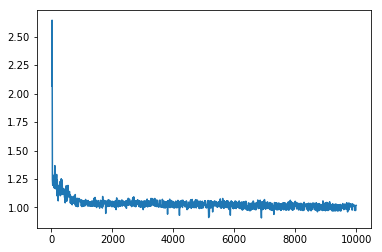

In [260]:
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output0, output1 = nnet(img0, img1)
        contrastive_loss = criterion(output0, output1, label)
        contrastive_loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch, contrastive_loss.item()))
            iteration += 10
            counter.append(iteration)
            loss_history.append(contrastive_loss.item())
    #scheduler.step()
show_plot(counter, loss_history)

# Testing

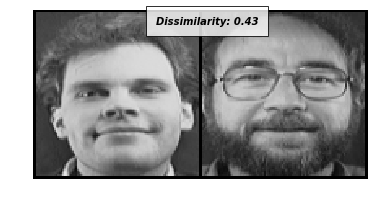

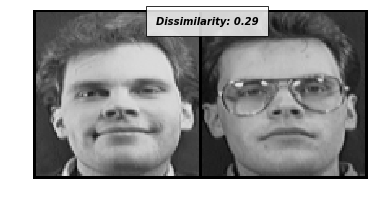

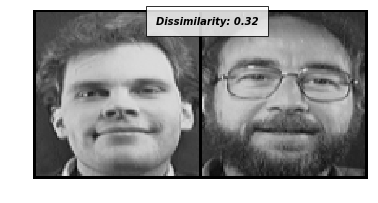

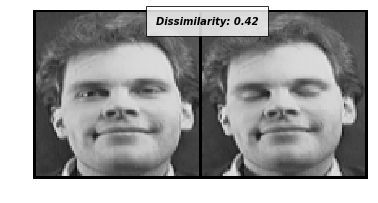

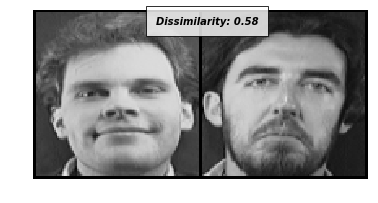

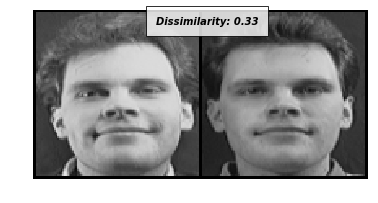

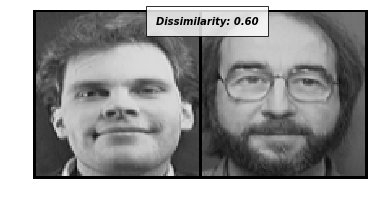

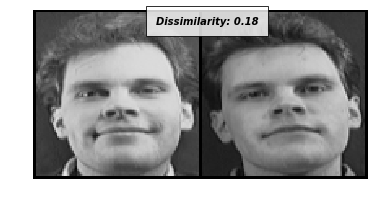

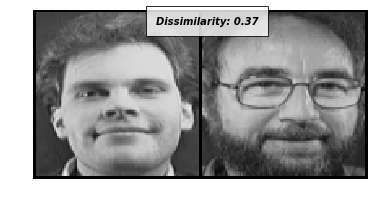

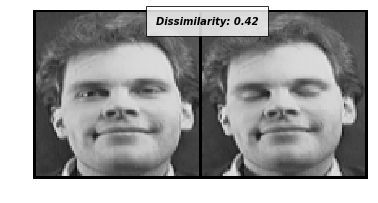

In [264]:
test_dataset = dset.ImageFolder(root=Config.test_dir)
faceid_dataset = FaceIdDataset(imageFolderDataset=test_dataset,
                               transform=transforms.Compose([transforms.Resize((100,100)),
                                                             transforms.ToTensor()]))

test_dataloader = DataLoader(faceid_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output0, output1 = nnet(Variable(x0).cuda(), Variable(x1).cuda())
    l2_norm = F.pairwise_distance(output0, output1)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(l2_norm.item()))